In [170]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
from joblib import dump, load

PREFIX='a video of '
events = [
    "Riding",
    "Fighting",
    "Playing",
    "Running",
    "Lying",
    "Chasing",
    "Jumping",
    "Falling",
    "Guiding",
    "Stealing",
    "Littering",
    "Tripping",
    "Pickpockering",
]
description = [
    "a person riding a bicycle on the street",  # Added context
    "multiple people engaged in a physical fight",  # More specific than "fighting"
    "a group of people playing a sport together",  # Added "sport" for visual clarity
    "a person running",  # Added context
    "a person lying motionless on the ground",  # "Motionless" helps distinguish from falling
    "a person aggressively chasing another person",  # "Aggressively" adds distinction
    "a person jumping high in the air with both feet",  # More specific than just "jumping"
    "a person accidentally falling to the ground",  # "Accidentally" helps distinguish
    "a person gently guiding another person by the arm",  # Added detail
    "a person stealing other person",  # More specific than "stealing"
    "a person deliberately throwing garbage on the ground",  # "Deliberately" adds clarity
    "a person tripping over an obstacle",  # More descriptive
    "a person pickpocketing a wallet from someone's pocket",  # Very specific
]
normal_prompt = "a normal view (persons walking or standing)"
description.append(normal_prompt)
description=[PREFIX +desc for desc in description]
events_description = {event: desc for event, desc in zip(events, description)}


In [171]:
stats= {
    'Total':0,
    'Score Evaluated': 0,
    'Score Not Evaluated': 0,
    'Maximum Score Event': 0,
    'Maximum Score No Event': 0,
    'Event in scores': 0,
    'Event in top 5':0,
    'Event in top 3':0
}
X = np.empty((0, 14
))  # j=13, so X will have shape (0, 13) and can be stacked with 1D arrays of length 13
y = np.array([])  # 3 classes (0, 1, 2)
def define_selected_event(predicted_event, probability, normal_class, true_class):
    if probability==0:
        return normal_class
    elif any(probability) == False:
        return normal_class
    probability=[min(1,prob) for prob in probability]
    probabilities_1=[prob for prob in probability if prob > 1]
    if probabilities_1!= []:
        print(np.argmax(probability), probability)
    global X,y
    X = np.vstack((X, probability))
    # true_class is a string, find its index in predicted_event
    #print("Predicted event:", true_class, predicted_event.index(true_class))
    if true_class in predicted_event:
        y = np.append(y, predicted_event.index(true_class))
    else:
        y = np.append(y, -1)  # or handle as needed if not found
    stats['Score Evaluated'] += 1
    '''clf_loaded = load('/home/ubuntu/Tesis/Storage/Score_Rules_NewScores/Model/logistic_regression_model.joblib')
    y_proba = clf_loaded.predict_proba(np.array([probability]))
    index = y_proba.argmax()
    print("Class probabilities:\n", y_proba)
    return predicted_event[index]'''
    thresholds = {
    "a person riding a bicycle on the street":0.01,
    "multiple people engaged in a physical fight":0.01,
    "a group of people playing a sport together":0.01,
    "a person running":0.25,
    "a person lying motionless on the ground":0.65,
    "a person aggressively chasing another person":0.75,
    "a person jumping high in the air with both feet":0.1,
    "a person accidentally falling to the ground":0.01,
    "a person gently guiding another person by the arm":0.05,
    "a person stealing other person":0.8,
    "a person deliberately throwing garbage on the ground":0.15,
    "a person tripping over an obstacle":0.85,
    "a person pickpocketing a wallet from someone's pocket":0.01,
    'a normal view (persons walking or standing)':0.0
    } 
    thresholds = {
    "a person riding a bicycle on the street":0.01,
    "multiple people engaged in a physical fight":0.1,
    "a group of people playing a sport together":0.01,
    "a person running":0.25,
    "a person lying motionless on the ground":0.65,
    "a person aggressively chasing another person":0.75,
    "a person jumping high in the air with both feet":0.01,
    "a person accidentally falling to the ground":0.01,
    "a person gently guiding another person by the arm":0.15,
    "a person stealing other person":0.80,
    "a person deliberately throwing garbage on the ground":0.15,
    "a person tripping over an obstacle":0.85,
    "a person pickpocketing a wallet from someone's pocket":0.01,
    'a normal view (persons walking or standing)':0.0
    } 
    scores = {
        event: prob
        for event, prob in zip(predicted_event, probability)
        if prob > thresholds[event.split(PREFIX)[-1]] and event!= normal_class
    }
    #print(scores)
    if not scores:
        stats['Score Not Evaluated'] += 1
        return normal_class
    if true_class in scores or true_class==normal_class:
        stats['Event in scores'] += 1
        '''return true_class'''
    # Get the top three scores sorted from max to min
    top3 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
    top3_events = [event for event, _ in top3]
    # If true_class is in the top three, return true_class
    if true_class in top3_events:
        stats['Event in top 3']+= 1
    top5 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:5]
    top5_events = [event for event, _ in top5]
    # If true_class is in the top five, return true_class
    if true_class in top5_events:
        stats['Event in top 5']+= 1
        print(true_class,top5)
    max_event = max(scores, key=scores.get)
    if max_event == true_class:
        stats['Maximum Score Event'] += 1
    else:
        stats['Maximum Score No Event'] += 1
    return max_event if scores[max_event] > 0 else normal_class
def check_precision(frames_number, name, predicted_events, event, description, prompts, mode, probabilities):
    # TN Prediction and Reality are true
    # TN Prediction and Reality are false
    # FN Prediction is false and Reality is true
    # FP Prediction is true and Reality is false
    normal_class = PREFIX + "a normal view (persons walking or standing)"
    #
    all_classes = description
    frames = np.load("/home/ubuntu/Database/ALL/GT/gt_ALL.npz")
    frames= frames[name]
    frames = np.append(frames, frames[-1])
    # Create a dictionary to convert class names to numeric indices
    class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
    # Example: {"a normal view...": 0, "a person riding...": 1, ...}
    num_classes = len(all_classes)  # 14
    cm = np.zeros((num_classes, num_classes), dtype=int)
    prompts = [prompt.lower().split('.')[0] for prompt in prompts]
    for i in range(len(predicted_events)):
        # Get ground truth
        is_anomaly = frames[frames_number[i] - 1]  # 0 or 1
        # Determine true class using EVENT when anomaly exists
        
        true_class = event if is_anomaly == 1 else normal_class
        #print(f"Event {true_class}: Probabilities: {probabilities[i]}")
        pred_class = define_selected_event(predicted_events[i], probabilities[i], normal_class, true_class)
        if (mode==0 or mode==2):
            pass
        elif prompts[i] == "yes":
            pass
        elif prompts[i] == "no":
            continue
        else:
            if true_class == pred_class:
                pass
            else:
                continue
        # Get predicted class
        
        # Convert to indices (skip if class not recognized)
        true_idx = class_to_idx.get(true_class, -1)
        pred_idx = class_to_idx.get(pred_class, -1)
        
        if true_idx != -1 and pred_idx != -1:
            cm[true_idx, pred_idx] += 1
    # Get the index of your event class
    event_idx = class_to_idx[event]
    

    # Calculate metrics ONLY for your event class
    tp = cm[event_idx, event_idx]  # TNs for event
    fp = np.sum(cm[:, event_idx]) - tp  # FPs (other classes predicted as event)
    fn =  np.sum(cm[event_idx, :]) - tp  # FNs (event misclassified as others)
    tn = np.sum(cm) - tp - fp - fn  # TNs
    return tp, fp, fn, tn, cm
        
    return 0,0,0,0,0
rute_stored="/home/ubuntu/Tesis/Storage/Score_Rules_NewScores"
files=os.listdir(rute_stored)
files = [f for f in files if f.endswith('.npy')]
df= pd.DataFrame(columns=['Name', 'Event', 'Mode', 'TP', 'FP', 'FN', 'TN'])
class_to_idx = {cls: idx for idx, cls in enumerate(description)}
# Example: {"a normal view...": 0, "a person riding...": 1, ...}
num_classes = len(description)  # 14
cm_sum = np.zeros((num_classes, num_classes), dtype=int)
count=0
df= pd.DataFrame(columns=['Name', 'Event', 'Mode', 'TP', 'FP', 'FN', 'TN'])
for file in files:
    #print(file)
    name= file.split('_CLIP_')[0]
    mode=int(file.split('_CLIP_')[1][0])
    event=file.split('_CLIP_')[1][2:].split('.')[0]
    info_stored=np.load(f"{rute_stored}/{file}", allow_pickle=True)
    frames_number=info_stored[0]
    predicted_events=info_stored[1]
    prompts=info_stored[2]
    probabilities=info_stored[3]
    stats['Total'] += len(frames_number)
    #print(len(frames_number), len(predicted_events), len(probabilities))
    tp, fp, fn, tn, cm=check_precision(frames_number, name, predicted_events, event,description, prompts, mode,probabilities)
    cm_sum += cm
    row = {
    'Name':name, 'Event':event, 'Mode':mode, 'TP':tp, 'FP':fp, 'FN':fn, 'TN':tn
    }
    df =pd.concat([df, pd.DataFrame([row])], ignore_index=True) 
print(df)

a video of a person running [('a video of a person gently guiding another person by the arm', 0.5719605433893306), ('a video of a person running', 0.4393667769558954), ('a video of a person deliberately throwing garbage on the ground', 0.37068949711988897)]
a video of a person running [('a video of a person running', 0.4361747777605997), ('a video of a person deliberately throwing garbage on the ground', 0.3683220691502029)]
a video of a person running [('a video of a person running', 0.5123168022479658), ('a video of a person deliberately throwing garbage on the ground', 0.40153680822704557)]
a video of a person running [('a video of a person tripping over an obstacle', 0.882444441318512), ("a video of a person pickpocketing a wallet from someone's pocket", 0.7787081920139407), ('a video of a person running', 0.5259266681599137), ('a video of a person deliberately throwing garbage on the ground', 0.4440333029861878), ('a video of a person gently guiding another person by the arm', 0.2

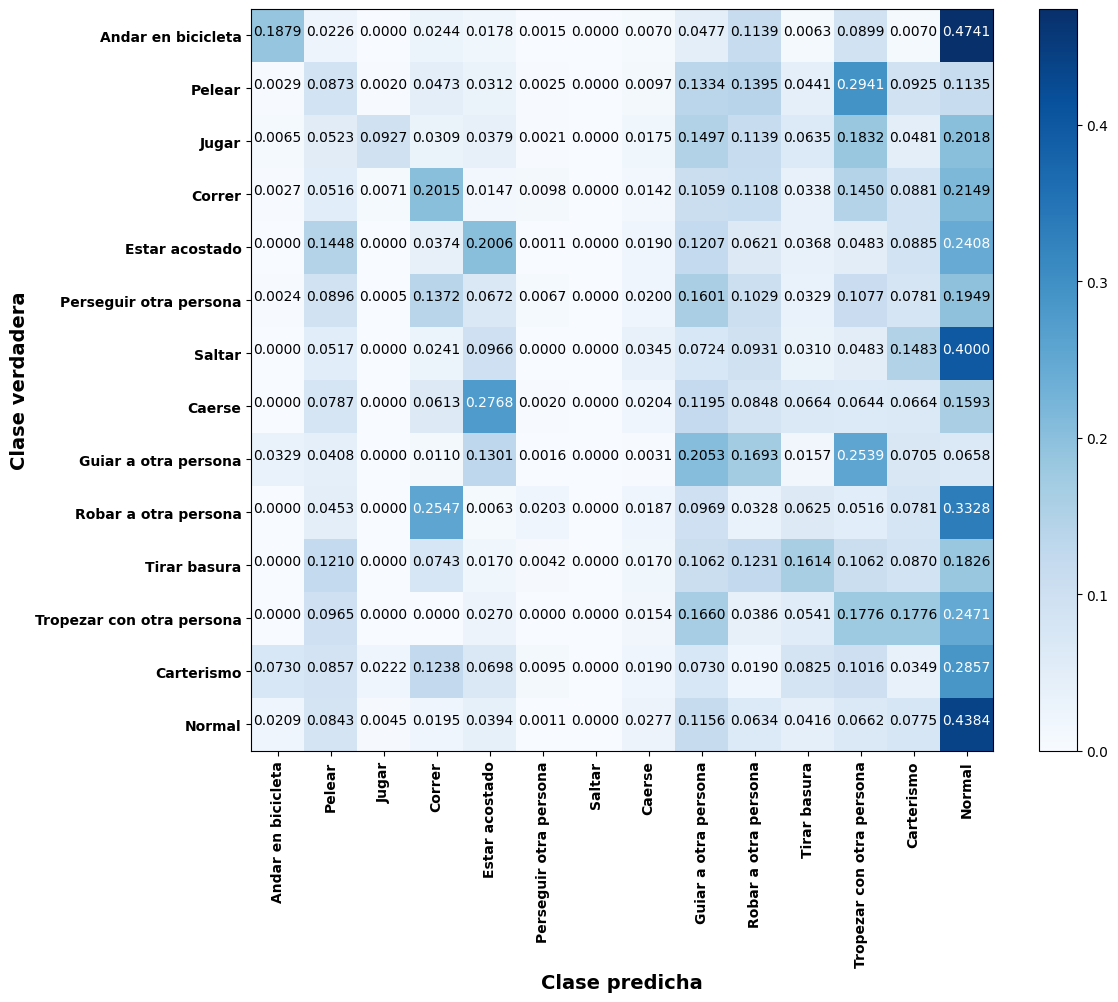

In [ ]:
plt.figure(figsize=(12, 10))
cm_sum = cm_sum / cm_sum.sum(axis=1, keepdims=True)
plt.imshow(cm_sum, interpolation='nearest', cmap=plt.cm.Blues)
#plt.title(f"Matriz de confusión: {mode_names[mode]}", fontsize=16, fontweight='bold')
plt.xlabel("Clase predicha", fontsize=14, fontweight='bold')
plt.ylabel("Clase verdadera", fontsize=14, fontweight='bold')
plt.colorbar()
# Replace class names with the ones from the replace list
replace = [
    "Andar en bicicleta",
    "Pelear",
    "Jugar",
    "Correr",
    'Estar acostado',
    "Perseguir otra persona",
    "Saltar",
    "Caerse",
    "Guiar a otra persona",
    "Robar a otra persona",
    "Tirar basura",
    "Tropezar con otra persona",
    "Carterismo",
    'Normal',
]
updated_classes = replace
tick_marks = np.arange(num_classes)   
plt.xticks(tick_marks, updated_classes, rotation=90, fontweight='bold')  # Rotate x-axis labels for better visibility
plt.yticks(tick_marks, updated_classes, fontweight='bold')   # Annotate the matrix with the values
thresh = cm_sum.max() / 2.0
for i, j in np.ndindex(cm_sum.shape):
    plt.text(j, i, f"{cm_sum[i, j]:.4f}",
                        horizontalalignment="center",
                        color="white" if cm_sum[i, j] > thresh else "black")   
plt.tight_layout()
plt.savefig(f"/home/ubuntu/Tesis/Results/Tesis/RulesWithScore/confusion_matrix_top5.png", bbox_inches='tight')
plt.show()

In [173]:
df_respaldo=df.copy()
#df_respaldo=df_respaldo.loc[~df_respaldo["Name"].str.endswith("_1")] 
print(df_respaldo)
df_sum = df_respaldo.groupby(["Event", "Mode"])[
    ["TP", "FP", "FN", "TN"]
].sum().reset_index()

# Initialize precision, recall, accuracy with zeros
df_sum["Precision"] = 0.0
df_sum["Recall"] = 0.0
df_sum["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_sum["TP"] + df_sum["FP"]) != 0
df_sum.loc[mask_prec, "Precision"] = (
    df_sum.loc[mask_prec, "TP"] / (df_sum.loc[mask_prec, "TP"] + df_sum.loc[mask_prec, "FP"])
)

mask_recall = (df_sum["TP"] + df_sum["FN"]) != 0
df_sum.loc[mask_recall, "Recall"] = (
    df_sum.loc[mask_recall, "TP"] / (df_sum.loc[mask_recall, "TP"] + df_sum.loc[mask_recall, "FN"])
)

mask_acc = (df_sum["TP"] + df_sum["FP"] + df_sum["FN"] + df_sum["TN"]) != 0
df_sum.loc[mask_acc, "Accuracy"] = (
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "TN"]) /
    (df_sum.loc[mask_acc, "TP"] + df_sum.loc[mask_acc, "FP"] + df_sum.loc[mask_acc, "FN"] + df_sum.loc[mask_acc, "TN"])
)
df_sum.drop(columns=['TP', 'FP', 'FN', 'TN'], inplace=True)
df_sum['F1'] = 2 * df_sum['Precision'].astype(float) * df_sum['Recall'].astype(float) / (df_sum['Precision'].astype(float) + df_sum['Recall'].astype(float))
df_sum['F1'].fillna(0, inplace=True)  # Handle division by zero
df_sum.drop(columns=['Event'], inplace=True)
df_sum=df_sum.groupby(["Mode"]).mean()
mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
df_sum.rename(index=mode_names, inplace=True)
print(df_sum)

        Name                                              Event Mode  TP  FP  \
0    4_110_1                        a video of a person running    0  18   6   
1    2_083_1  a video of a person aggressively chasing anoth...    0   0   0   
2         20  a video of a person deliberately throwing garb...    0   0   1   
3    3_095_1  a video of a person deliberately throwing garb...    0   2   0   
4    4_107_1  a video of a person aggressively chasing anoth...    0   0   0   
..       ...                                                ...  ...  ..  ..   
247  4_109_1  a video of a group of people playing a sport t...    0   1   0   
248  4_105_1  a video of multiple people engaged in a physic...    0  10   5   
249  4_082_1  a video of multiple people engaged in a physic...    0   9   0   
250   000259                        a video of a person running    0   0   0   
251  1_088_1  a video of multiple people engaged in a physic...    0   6  24   

      FN   TN  
0     17   72  
1    23

/tmp/ipykernel_21509/2034563803.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.8816901408450705 0.46511627906976744 0.9333333333333333
 0.3671497584541063 0.803680981595092 0.691089108910891 0.2
 0.9941291585127201 0.7823834196891192 0.2692307692307692
 0.9787234042553191 0.4600715137067938]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_sum.loc[mask_prec, "Precision"] = (
/tmp/ipykernel_21509/2034563803.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.09268581581285164 0.020429009193054137 0.006669842782277275
 0.1613588110403397 0.20532915360501566 0.0 0.20057471264367815
 0.03492063492063492 0.1878698224852071 0.20151245551601424 0.0328125
 0.1776061776061776 0.08727108297535609]' has dtype incompatible with float64, please explicitly cast to a compatible d

In [174]:
def calculate_ap(precision, recall):
    # Sort by recall (ascending)
    sorted_indices = np.argsort(recall)
    precision = np.array(precision)[sorted_indices]
    recall = np.array(recall)[sorted_indices]

    # Pad with (0,0) and (1,0)
    precision = np.concatenate(([0], precision, [0]))
    recall = np.concatenate(([0], recall, [1]))

    # Compute AP as the area under the raw curve (no interpolation)
    ap = 0.0
    for i in range(1, len(recall)):
        delta_recall = recall[i] - recall[i - 1]
        ap += delta_recall * precision[i]

    return ap
df_check = df_respaldo.copy()

# Initialize precision, recall, accuracy with zeros
df_check["Precision"] = 0.0
df_check["Recall"] = 0.0
df_check["Accuracy"] = 0.0

# Calculate only where the denominator is not zero
mask_prec = (df_check["TP"] + df_check["FP"]) != 0
df_check.loc[mask_prec, "Precision"] = (
    df_check.loc[mask_prec, "TP"] / (df_check.loc[mask_prec, "TP"] + df_check.loc[mask_prec, "FP"])
)

mask_recall = (df_check["TP"] + df_check["FN"]) != 0
df_check.loc[mask_recall, "Recall"] = (
    df_check.loc[mask_recall, "TP"] / (df_check.loc[mask_recall, "TP"] + df_check.loc[mask_recall, "FN"])
)

mask_acc = (df_check["TP"] + df_check["FP"] + df_check["FN"] + df_check["TN"]) != 0
df_check.loc[mask_acc, "Accuracy"] = (
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "TN"]) /
    (df_check.loc[mask_acc, "TP"] + df_check.loc[mask_acc, "FP"] + df_check.loc[mask_acc, "FN"] + df_check.loc[mask_acc, "TN"])
)
df_check['F1'] = 2 * df_check['Precision'].astype(float) * df_check['Recall'].astype(float) / (df_check['Precision'].astype(float) + df_check['Recall'].astype(float))
df_check['F1'].fillna(0, inplace=True)  # Handle division by zero
categories = df_check["Event"].unique()
# Separate rows by category
df_check = df_check.copy()
for column in df_check.select_dtypes(include=['category']).columns:
    df_check[column] = df_check[column].astype(str)
df_check.fillna(0, inplace=True)
category_dfs = {category: df_check[df_check["Event"] == category] for category in categories}

mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    #
    grouped = df1.groupby("Mode")
    # ----------------------------------------------------------------------
    # Ejecución del código
    ap_values = {}
    for mode, group in grouped:
        precision = np.array(group["Precision"].values)
        recall = np.array(group["Recall"].values)
        #print("Mode:", mode, "\n")
        #print("Precision:", precision, "Recall:", recall)
        # Comenta la siguiente línea para verificar si el error es aquí
        ap = calculate_ap(precision, recall)
        ap_values[mode] = ap
        #print(f'{mode} {categories[i]} AP: {ap:.4f}')
    mean_values = grouped[["Precision", "Recall",  "F1"]].mean()
    mean_values["AP"] = [ap_values[mode] for mode in mean_values.index]
    mean_values = mean_values[["AP"]]
    mAP_process.append(mean_values)
    # Plot the results
    mode_names = {
        0: "CLIP y Reglas",
        1: "CLIP y Reglas con MLLM",
        2: "CLIP y Reglas Una clase",
    }
    mean_values.rename(index=mode_names, inplace=True)
    # plt.xlim(0.4)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values2 = pd.concat(mAP_process).groupby(level=0).mean()
print(mAP_values2)

                     AP
Mode                   
CLIP y Reglas  0.315492


/tmp/ipykernel_21509/4034585013.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.75 0.0 1.0 0.2222222222222222 1.0 1.0 0.6666666666666666
 0.3333333333333333 1.0 1.0 0.6 1.0 1.0 0.0 0.0 0.3404255319148936 0.5 1.0
 1.0 0.2978723404255319 0.5818181818181818 1.0 0.8333333333333334 1.0
 0.7272727272727273 0.96 0.7 0.18181818181818182 0.7777777777777778 1.0
 1.0 1.0 1.0 0.9473684210526315 0.5 1.0 0.96875 0.7916666666666666
 0.7741935483870968 1.0 1.0 1.0 0.4 0.8888888888888888 0.2 1.0 0.5 1.0 1.0
 1.0 1.0 0.5833333333333334 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
 0.5789473684210527 0.6666666666666666 1.0 1.0 0.8571428571428571 1.0 1.0
 0.36363636363636365 1.0 0.0 0.0 0.0 0.07142857142857142 1.0 0.5 1.0 1.0
 0.18518518518518517 1.0 1.0 0.8225806451612904 0.6 0.0 0.59375 1.0
 0.9166666666666666 0.9887640449438202 0.0 0.9333333333333333 0.5 1.0
 0.5862068965517241 1.0 0.75 1.0 1.0 0.9 0.8571428571428571 

In [175]:
df_fps= pd.read_csv("/home/ubuntu/Tesis/Results/TestingMCRulesNewScore.csv")
print(df_fps["Process time"].sum()/(60*60), "hours\n\n")
df_fps["Process time"] = df_fps["Process time"] / df_fps["Duration"]
df_fps.loc[df_fps["Name"].str.contains("_1.mp4"), "Process time"] = (
        30.0 / df_fps["Process time"]
    )
df_fps.loc[~df_fps["Name"].str.contains("_1.mp4"), "Process time"] = (
        25.0 / df_fps["Process time"]
    )
categories = df_fps["True Event"].unique()
category_dfs = {category: df_fps[df_fps["True Event"] == category] for category in categories}
print(categories)
mAP_process = []
for i in range(len(categories)):
    df1 = category_dfs[categories[i]]
    grouped = df1.groupby("Mode")
    mean_values = grouped[["Process time"]].mean()
    mean_values = mean_values[["Process time"]]
    mAP_process.append(mean_values)
# Calculate the mean Average Precision (mAP) for each mode
mAP_values = pd.concat(mAP_process).groupby(level=0).mean()
print("\n\n", mAP_values)

7.519240502913793 hours


['a video of a person riding a bicycle on the street'
 'a video of multiple people engaged in a physical fight'
 'a video of a group of people playing a sport together'
 'a video of a person running'
 'a video of a person lying motionless on the ground'
 'a video of a person aggressively chasing another person'
 'a video of a person jumping high in the air with both feet'
 'a video of a person accidentally falling to the ground'
 'a video of a person gently guiding another person by the arm'
 'a video of a person stealing other person'
 'a video of a person deliberately throwing garbage on the ground'
 'a video of a person tripping over an obstacle'
 "a video of a person pickpocketing a wallet from someone's pocket"]


       Process time
Mode              
0        12.953269


In [176]:
print(stats)

{'Total': 47092, 'Score Evaluated': 44210, 'Score Not Evaluated': 12659, 'Maximum Score Event': 2641, 'Maximum Score No Event': 28910, 'Event in scores': 20222, 'Event in top 5': 6837, 'Event in top 3': 5398}


In [177]:
df= pd.DataFrame(columns=['Event', 'Threshold', 'Precision', 'Recall', 'F1 Score'])
for i in range(X.shape[1]-1):
    for threshold in np.arange(0.01, 1, 0.01):  # You can adjust the threshold as needed
        gt=np.where(y == i, 1, 0)  # Ground truth for the current class
        scores = X[:, i]  # Scores for the current class
        tp = np.sum((scores >= threshold) & (gt == 1))
        fp = np.sum((scores >= threshold) & (gt == 0))
        fn = np.sum((scores < threshold) & (gt == 1))
        tn = np.sum((scores < threshold) & (gt == 0))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall)  if (precision + recall) > 0 else 0
        print(f"Event: {events[i]}, Threshold: {threshold}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")
        df.loc[len(df)] = {'Event': events[i], 'Threshold': threshold, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}
print(df)

Event: Riding, Threshold: 0.01, Precision: 0.3958855995985951, Recall: 0.44880546075085326, F1 Score: 0.4206878165822447
Event: Riding, Threshold: 0.02, Precision: 0.40224604389994895, Recall: 0.4482366325369738, F1 Score: 0.42399784772666127
Event: Riding, Threshold: 0.03, Precision: 0.40892579138557344, Recall: 0.4482366325369738, F1 Score: 0.4276797829036635
Event: Riding, Threshold: 0.04, Precision: 0.4158311345646438, Recall: 0.4482366325369738, F1 Score: 0.4314262250205311
Event: Riding, Threshold: 0.05, Precision: 0.42486486486486486, Recall: 0.447098976109215, F1 Score: 0.4356984478935698
Event: Riding, Threshold: 0.060000000000000005, Precision: 0.4369093941078377, Recall: 0.447098976109215, F1 Score: 0.4419454596570143
Event: Riding, Threshold: 0.06999999999999999, Precision: 0.4469178082191781, Recall: 0.4453924914675768, F1 Score: 0.4461538461538461
Event: Riding, Threshold: 0.08, Precision: 0.4544924154025671, Recall: 0.4431171786120592, F1 Score: 0.4487327188940092
Event: